# Uncertainty estimation for logistic regression class room example

In this notebook you will find an explanation of uncertainty estimation for logistic regression    
It is a lab experiment with fake idealized data, so that we know exactly what should come out and can compare  

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics

# The errortools module
import errortools

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sphinxcontrib: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/Library/Frameworks/

## A fake idealized dataset

We create a fake idealized dataset, a lab experiment, so that we have complete control over features and data size,
and most importantly we can create a target that truly follows a logistic function  
In this way we know "the truth", i.e. we know exactly what parameters the logistic regression classifier ideally should train to, and we know exactly what prediction curves the trained classifier ideally should produce

### Lab settings
Here we define the parameters that control the dataset
- Number of input features
- Whether to use an intercept
- Number of (training) data points
- The true parameters that define the logistic function

In [2]:
# Number of input dimensions/features
n_dim = 3

# Whether to fit the intercept
fit_intercept = True

# Number of training data points
n_traindata = 100

# True logistic regression parameters
# Initialize to zeros
p_true = [0]*(n_dim+1)
# Set some values
p_true[0] = 2
p_true[2] = -2
# The last one is the bias/intercept
p_true[-1] = 1

#### Draw the logistic function in the various input dimensions

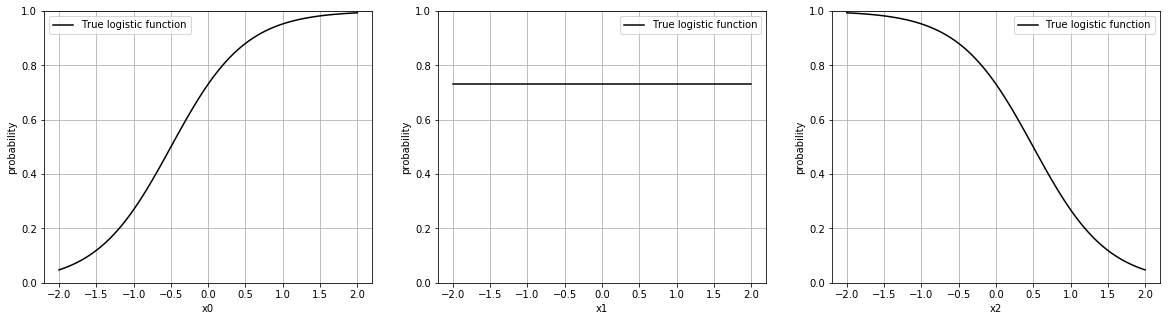

In [3]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)


# Draw curves along each of the dimesions on the following points
u = np.linspace(-2, 2, 100)


# We keep the other dimensions at zero
zeros = np.zeros(100, dtype=float)
# and add ones for the bias/intercept
ones = np.ones((100,1), dtype=float)


fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    left = np.tile(zeros, (i,1)).T
    right = np.tile(zeros, (n_dim-i-1,1)).T
    if i==0:
        U = np.concatenate((u.reshape(-1,1), right, ones), axis=1)
    elif i+1==n_dim:
        U = np.concatenate((left, u.reshape(-1,1), ones), axis=1)
    else:
        U = np.concatenate((left, u.reshape(-1,1), right, ones), axis=1)
    p = scipy.stats.logistic.cdf(np.dot(U, p_true))
    ax[i//n_horizontal, i%n_horizontal].plot(u, p, '-', color='black', alpha=1, label="True logistic function")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("probability")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].set_ylim((0,1))
    ax[i//n_horizontal, i%n_horizontal].legend()

### Generate the dataset

The dataset is randomly generated according to a logistic probability function  
The input features we take from -1 to 1  

In [4]:
# Set a seed for reproducability
np.random.seed(42)

# Generate the input feature set
X = np.random.uniform(low=-1, high=1, size=(n_traindata, n_dim,))

# Calculate the probabilities for each point to be positive
p = scipy.stats.logistic.cdf(np.dot(np.concatenate((X, np.ones((X.shape[0],1), dtype=float)), axis=1), p_true))

# Generate the targets
y = (p > np.random.uniform(size=n_traindata)).astype(int)

#### Visualize the data in the various dimensions

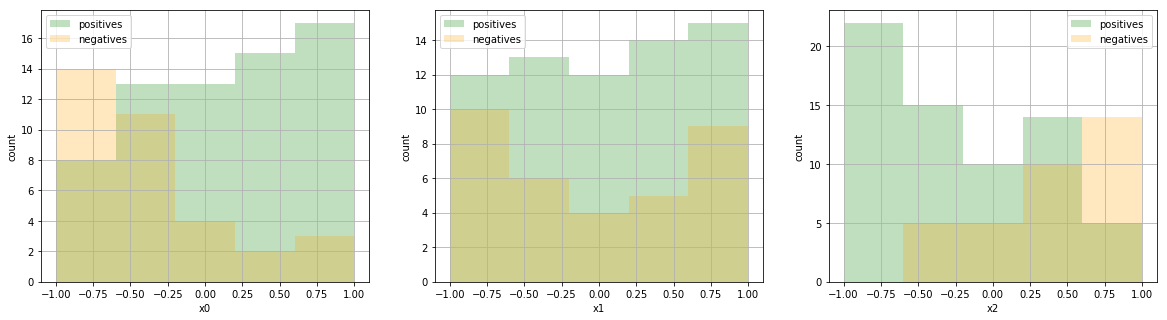

In [5]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)

X_positive = X[y==1]
X_negative = X[y==0]
n_bins = n_traindata//20

fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    ax[i//n_horizontal, i%n_horizontal].hist(X_positive[:,i], bins=n_bins, range=(-1,1), color='green',  alpha=0.25, label="positives")
    ax[i//n_horizontal, i%n_horizontal].hist(X_negative[:,i], bins=n_bins, range=(-1,1), color='orange', alpha=0.25, label="negatives")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("count")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].legend()

## Fitting the dataset

The `LogisticRegression` class in `errortools` can fit and predict just like its sklearn equivalent  
It uses _Minuit_ for fitting, an age-old robust minimization package

In [6]:
# Initiate the logistic regression model
model = errortools.LogisticRegression()

# Fit the model to 
model.fit(X,y)

#### Fit results

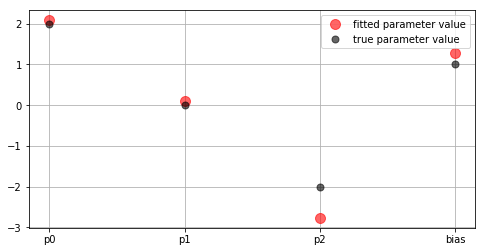

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(np.arange(n_dim+1), model.parameters, 'o', color='red',  alpha=0.6, markersize=10, label='fitted parameter value')
ax.plot(np.arange(n_dim+1), p_true, 'o', color='black',  alpha=0.6, markersize=7, label='true parameter value')
ax.grid()
ax.legend()
ax.xaxis.set_ticks(np.arange(n_dim+1))
ax.xaxis.set_ticklabels(['p{:d}'.format(i) for i in range(n_dim)]+ ['bias']);

#### Refitting

You can refit a model. 
The fitter will continue where it left of, with the last parameter values, step sizes, limits and which ones are held fixed. 
Unless you specifiy any of these differently in the new fit.  
An example is given below. 
We force the first parameter to be less than zero and fix the last parameter (the bias) to its current value, and refit

In [8]:
parameter_limits = [None]*(n_dim+1)
parameter_limits[0] = (None,0)

parameter_fixes = [False]*(n_dim+1)
parameter_fixes[-1] = True

previous_parameters = model.parameters
model.fit(X, y, parameter_limits=parameter_limits, parameter_fixes=parameter_fixes)

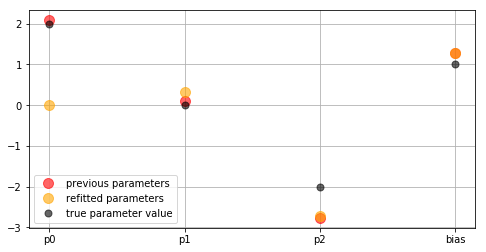

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(np.arange(n_dim+1), previous_parameters, 'o', color='red',  alpha=0.6, markersize=10, label='previous parameters')
ax.plot(np.arange(n_dim+1), model.parameters, 'o', color='orange',  alpha=0.6, markersize=10, label='refitted parameters')
ax.plot(np.arange(n_dim+1), p_true, 'o', color='black',  alpha=0.6, markersize=7, label='true parameter value')
ax.grid()
ax.legend()
ax.xaxis.set_ticks(np.arange(n_dim+1))
ax.xaxis.set_ticklabels(['p{:d}'.format(i) for i in range(n_dim)]+ ['bias']);

...And back to the original fit

In [10]:
model.fit(X, y, parameter_limits=False, parameter_fixes=False)

#### Visualising the fitted model's prediction curves

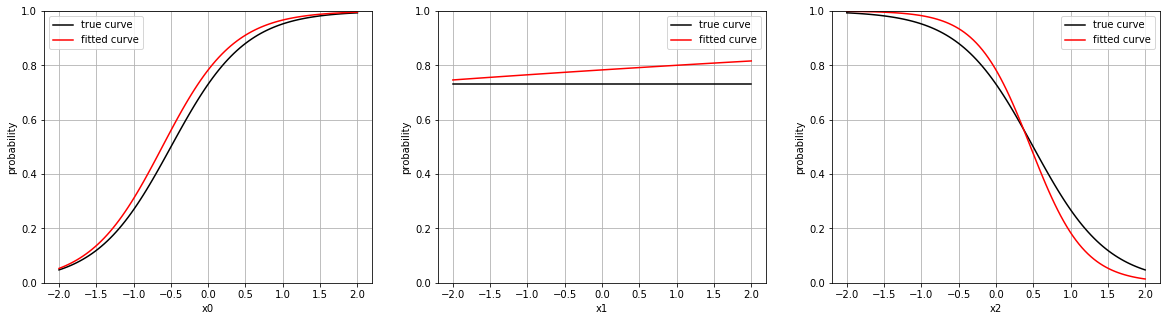

In [11]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)

# Draw curves along each of the dimesions on the following points
u = np.linspace(-2, 2, 100)


# We keep the other dimensions at zero
zeros = np.zeros(100, dtype=float)
# and add ones for the bias/intercept
ones = np.ones((100,1), dtype=float)


fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    left = np.tile(zeros, (i,1)).T
    right = np.tile(zeros, (n_dim-i-1,1)).T
    if i==0:
        U = np.concatenate((u.reshape(-1,1), right, ones), axis=1)
    elif i+1==n_dim:
        U = np.concatenate((left, u.reshape(-1,1), ones), axis=1)
    else:
        U = np.concatenate((left, u.reshape(-1,1), right, ones), axis=1)
    p = scipy.stats.logistic.cdf(np.dot(U, p_true))
    ax[i//n_horizontal, i%n_horizontal].plot(u, p, '-', color='black', alpha=1, label="true curve")
    U = np.concatenate((left, u.reshape(-1,1), right,), axis=1)
    f = model.predict(U)
    ax[i//n_horizontal, i%n_horizontal].plot(u, f, '-', color='red', label="fitted curve")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("probability")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].set_ylim((0,1))
    ax[i//n_horizontal, i%n_horizontal].legend()

In a maximum likelihood fit we get the best fitting parameters __to the dataset__.
These are not entirely the same as the true parameters that created the dataset,
as you can see by comparing true and fitter parameters or true and fitted prediction curves above  
The reason is the dataset.
If we would have a different dataset, then we would fit to different parameters.
Because a different dataset would have different values for the features,
or would have some positives/ones where this set has negatives/zeros,
all in all influencing where the likelihood takes its maximum.  
This is easily shown by generating a bunch of datasets and fitting each one

## Repeat on different random datasets

Because we don't have infinite data, the fitted parameters are not equal to the true parameters that created the dataset   
If we repeat with different randomly created datasets, then we get different fitted parameters each time.
However, they should vary around the true parameter values

In [12]:
n_datasets = 1000

#### Random datasets

In [13]:
np.random.seed(42)
X_n = np.random.uniform(low=-1, high=1, size=(n_datasets, n_traindata, n_dim,))
p_n = scipy.stats.logistic.cdf(np.dot(np.concatenate((X_n, np.ones((X_n.shape[0], X_n.shape[1],1), dtype=float)), axis=2), p_true))
y_n = (p_n > np.random.uniform(size=(n_datasets, n_traindata))).astype(int)

#### Fit each dataset with a model

In [14]:
models = [None]*n_datasets
for i in range(n_datasets):
    models[i] = errortools.LogisticRegression()
    models[i].fit(X_n[i],y_n[i])

#### Plot the distribution of fit parameters from the various models

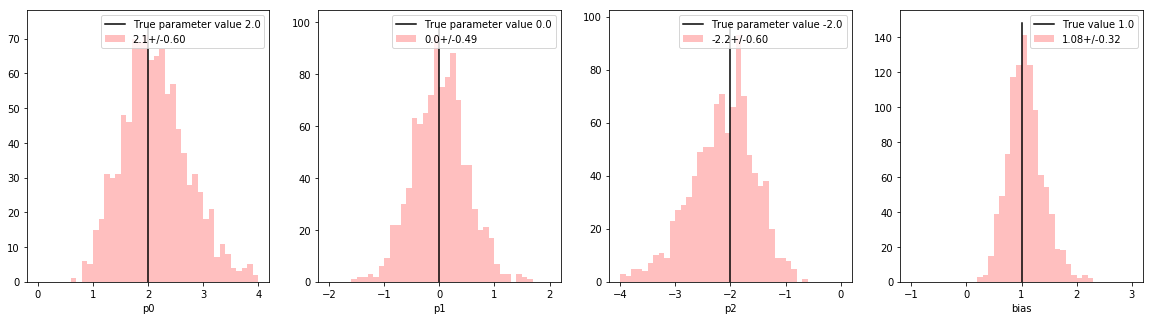

In [15]:
n_horizontal = min(4, n_dim+1)
n_vertical = (n_dim+1) // n_horizontal + ((n_dim+1) % n_horizontal > 0)

fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    t = [m.parameters[i] for m in models]
    ax[i//n_horizontal, i%n_horizontal].hist(t, bins=40, range=(p_true[i]-2, p_true[i]+2), alpha=0.25, color='red', label="{:.1f}+/-{:.2f}".format(np.mean(t), np.std(t)))
    ax[i//n_horizontal, i%n_horizontal].plot([p_true[i], p_true[i]], ax[i//n_horizontal, i%n_horizontal].get_ylim(), color='black', label="True parameter value {:.1f}".format(p_true[i]))
    ax[i//n_horizontal, i%n_horizontal].legend()
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("p{:d}".format(i))
t = [m.parameters[n_dim] for m in models]
ax[n_dim//n_horizontal, n_dim%n_horizontal].hist(t, bins=40, range=(p_true[-1]-2, p_true[-1]+2), alpha=0.25, color='red', label="{:.2f}+/-{:.2f}".format(np.mean(t), np.std(t)))
ax[n_dim//n_horizontal, n_dim%n_horizontal].plot([p_true[-1], p_true[-1]], ax[n_dim//n_horizontal, n_dim%n_horizontal].get_ylim(), color='black', label="True value {:.1f}".format(p_true[-1]))
ax[n_dim//n_horizontal, n_dim%n_horizontal].legend()
ax[n_dim//n_horizontal, n_dim%n_horizontal].set_xlabel("bias");


The parameters of the logistic regression can vary a lot from dataset to dataset

#### Plot the band of prediction curves that the different models give

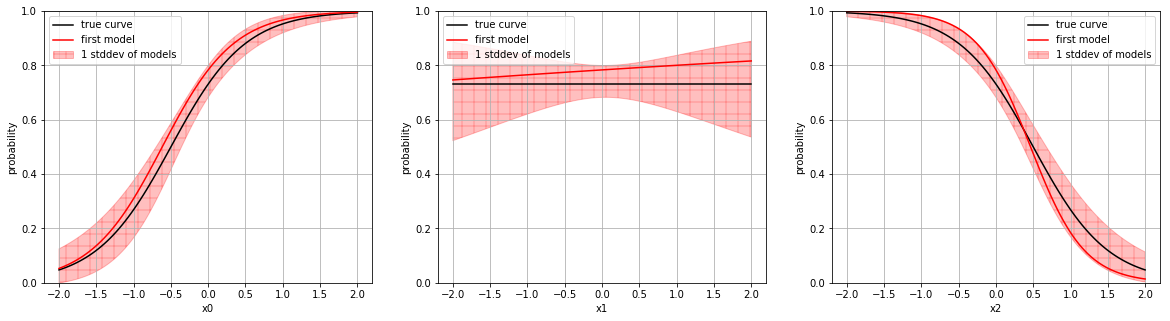

In [16]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)

# Draw curves along each of the dimesions on the following points
u = np.linspace(-2, 2, 100)


# We keep the other dimensions at zero
zeros = np.zeros(100, dtype=float)
# and add ones for the bias/intercept
ones = np.ones((100,1), dtype=float)


fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    left = np.tile(zeros, (i,1)).T
    right = np.tile(zeros, (n_dim-i-1,1)).T
    if i==0:
        U = np.concatenate((u.reshape(-1,1), right, ones), axis=1)
    elif i+1==n_dim:
        U = np.concatenate((left, u.reshape(-1,1), ones), axis=1)
    else:
        U = np.concatenate((left, u.reshape(-1,1), right, ones), axis=1)
    p = scipy.stats.logistic.cdf(np.dot(U, p_true))
    ax[i//n_horizontal, i%n_horizontal].plot(u, p, '-', color='black', alpha=1, label="true curve")
    U = np.concatenate((left, u.reshape(-1,1), right,), axis=1)
    high, low = [(a.mean(axis=0)+a.std(axis=0), a.mean(axis=0)-a.std(axis=0)) for a in [np.array([m.predict(U) for m in models])]][0]
    ax[i//n_horizontal, i%n_horizontal].fill_between(x=u, y1=low, y2=high, color='red', alpha=0.25, hatch='+', label="1 stddev of models")  
    f = model.predict(U)
    ax[i//n_horizontal, i%n_horizontal].plot(u, f, '-', color='red', label="first model")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("probability")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].set_ylim((0,1))
    ax[i//n_horizontal, i%n_horizontal].legend()


If we repeat with different randomly created datasets, then we get different fitted parameters each time.
And they vary around the true parameter values  
This is comforting, but can we estimate how far from the true parameter values we could be off for a single dataset?  
We can, with errortools

## Estimating uncertainties

Uncertainties on parameters are estimated using a parabolic approximation:
The negative log-likelihood (loss function) is locally approximated around its minimum with a multivariate parabola.
This is equivalent to approximating the likelihood locally as a multivariate normal distribution.
The variances and covariances of the parameters then roll straight out; they are the inverse Hessian matrix of the parabolic approximation, i.e. the covariance matrix of the multivariate normal.

If you don't care about mathematical details, then you can skip ahead

### Uncertainties on parameters

The parameter uncertainties are available with `model.errors`  
And by the way the full covariance matrix is also available via `model.cvr_mtx`  

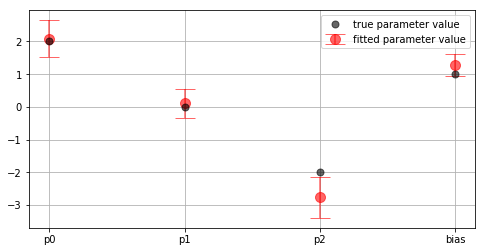

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(x=np.arange(n_dim+1), y=model.parameters, yerr=model.errors, fmt='o', color='red',  alpha=0.6, markersize=10, barsabove=True, capsize=10, label='fitted parameter value')
ax.plot(np.arange(n_dim+1), p_true, 'o', color='black',  alpha=0.6, markersize=7, label='true parameter value')
ax.grid()
ax.legend()
ax.xaxis.set_ticks(np.arange(n_dim+1))
ax.xaxis.set_ticklabels(['p{:d}'.format(i) for i in range(n_dim)]+ ['bias']);

Uncertainties on parameters means uncertainties on predictions  
There are various ways to propagate the uncertainties of the parameters to uncertainties on predictions made with the parameters.
They differ in that they employ different approximations or numerical methods.
This makes them somewhat different in speed, accuracy and even interpretation,
but they should give roughly similar numbers

The method `estimate_errors_interval` calculates asymmetric error intervals, by looking how far a parameter has to deviate from its optimal value to raise the negative log-likelihood (the loss) by 1/2

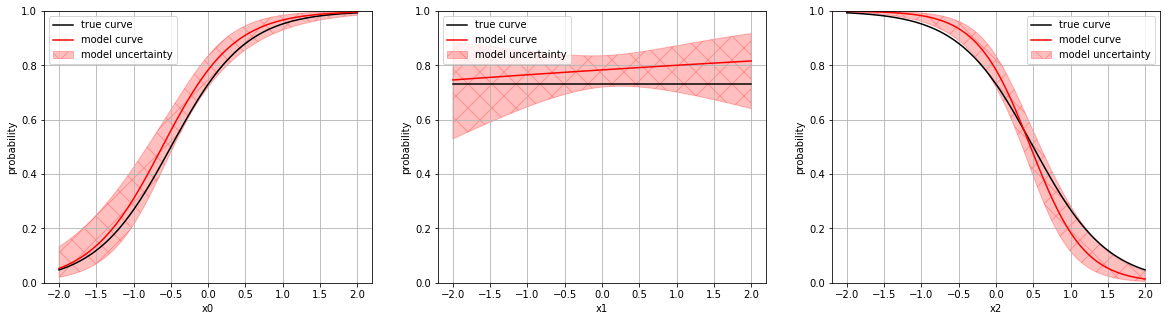

In [18]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)

# Draw curves along each of the dimesions on the following points
u = np.linspace(-2, 2, 100)


# We keep the other dimensions at zero
zeros = np.zeros(100, dtype=float)
# and add ones for the bias/intercept
ones = np.ones((100,1), dtype=float)


fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    left = np.tile(zeros, (i,1)).T
    right = np.tile(zeros, (n_dim-i-1,1)).T
    if i==0:
        U = np.concatenate((u.reshape(-1,1), right, ones), axis=1)
    elif i+1==n_dim:
        U = np.concatenate((left, u.reshape(-1,1), ones), axis=1)
    else:
        U = np.concatenate((left, u.reshape(-1,1), right, ones), axis=1)
    p = scipy.stats.logistic.cdf(np.dot(U, p_true))
    ax[i//n_horizontal, i%n_horizontal].plot(u, p, '-', color='black', alpha=1, label="true curve")
    U = np.concatenate((left, u.reshape(-1,1), right,), axis=1)
    f = model.predict(U)
    err_dwn, err_up = model.estimate_errors_interval(U)
    ax[i//n_horizontal, i%n_horizontal].fill_between(x=u, y1=f-err_dwn, y2=f+err_up, color='red', alpha=0.25, hatch='x', label="model uncertainty")  
    ax[i//n_horizontal, i%n_horizontal].plot(u, f, '-', color='red', label="model curve")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("probability")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].set_ylim((0,1))
    ax[i//n_horizontal, i%n_horizontal].legend()


The method `estimate_error_linear` makes an approximation of the standard deviation of a prediction via linear error propagation, while the method `estimate_errors_sampling` does the same via sampling the posterior

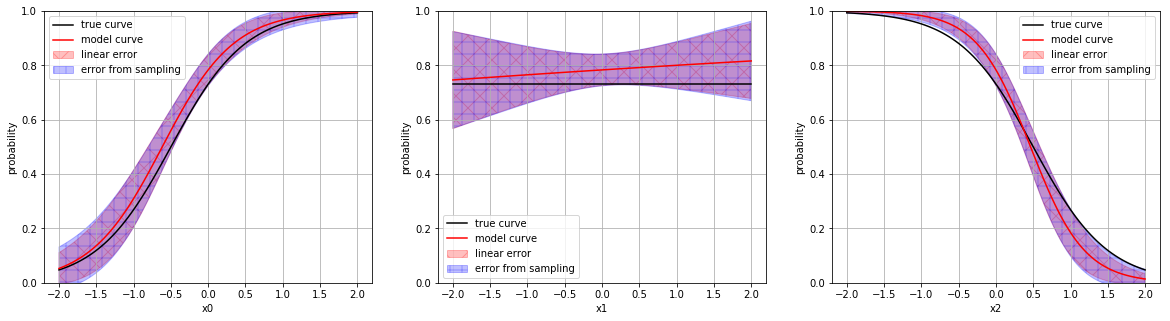

In [25]:
n_horizontal = min(4, n_dim)
n_vertical = n_dim // n_horizontal + (n_dim % n_horizontal > 0)

# Draw curves along each of the dimesions on the following points
u = np.linspace(-2, 2, 100)


# We keep the other dimensions at zero
zeros = np.zeros(100, dtype=float)
# and add ones for the bias/intercept
ones = np.ones((100,1), dtype=float)


fig, ax = plt.subplots(n_vertical, n_horizontal, figsize=(20, 5*n_vertical))
ax = np.atleast_2d(ax)
for i in range(n_dim):
    left = np.tile(zeros, (i,1)).T
    right = np.tile(zeros, (n_dim-i-1,1)).T
    if i==0:
        U = np.concatenate((u.reshape(-1,1), right, ones), axis=1)
    elif i+1==n_dim:
        U = np.concatenate((left, u.reshape(-1,1), ones), axis=1)
    else:
        U = np.concatenate((left, u.reshape(-1,1), right, ones), axis=1)
    p = scipy.stats.logistic.cdf(np.dot(U, p_true))
    ax[i//n_horizontal, i%n_horizontal].plot(u, p, '-', color='black', alpha=1, label="true curve")
    U = np.concatenate((left, u.reshape(-1,1), right,), axis=1)
    f = model.predict(U)
    err_lin = model.estimate_errors_linear(U)
    err_smpl = model.estimate_errors_sampling(U)
    ax[i//n_horizontal, i%n_horizontal].fill_between(x=u, y1=f-err_lin, y2=f+err_lin, color='red', alpha=0.25, hatch='x', label="linear error") 
    ax[i//n_horizontal, i%n_horizontal].fill_between(x=u, y1=f-err_smpl, y2=f+err_smpl, color='blue', alpha=0.25, hatch='+', label="error from sampling")  
    ax[i//n_horizontal, i%n_horizontal].plot(u, f, '-', color='red', label="model curve")
    ax[i//n_horizontal, i%n_horizontal].set_xlabel("x{:d}".format(i))
    ax[i//n_horizontal, i%n_horizontal].set_ylabel("probability")
    ax[i//n_horizontal, i%n_horizontal].grid()
    ax[i//n_horizontal, i%n_horizontal].set_ylim((0,1))
    ax[i//n_horizontal, i%n_horizontal].legend()


## Judging the validity of the model

Above we show how `errortools` estimates uncertainties on model parameters and predictions  
However, these are statistical uncertainties.
Meaning that they only include uncertainties due to limited data;
if we had a different dataset we would find different model parameters and predictions curves  
What they do not take into account is the possibility that the model is not the right one for the job;
the target may not linearly depend on the input features, or not follow a logistic probability  

Below we show one way in which we can judge the validity of the logistic model itself for a classification task  
The score that the model gives should be resprentative for the probability to be positive.
Therefore the fraction of positives we find for each value of the score should equal the score itself, 
to within errors  
We test this on two test sets:  
The first prepared with the logistic model itself.
The fraction of positives should equal the score  
The second prepared with a normal distribution.
The fraction of positives will deviate from the score

In [21]:
# Helper function to calculate the postive ratio and its error
def get_positive_ratio(model, X, y, n_samples=1000, bins=20):
    y_pred = model.predict(X)
    H_all, e = np.histogram(y_pred, bins=bins, range=(0,1))
    H_pos, e = np.histogram(y_pred[y==1], bins=bins, range=(0,1))
    ratio = H_pos.astype(float)/(H_all+1e-12)
    
    p = np.random.multivariate_normal(mean=model.parameters, cov=model.cvr_mtx, size=n_samples)
    y_pred = 1./(1.+np.exp(-np.dot(p, np.concatenate((X,np.ones((X.shape[0],1))), axis=1).T)))
    H_all = np.array([np.histogram(v, bins=bins, range=(0,1))[0] for v in y_pred])
    H_pos = np.array([np.histogram(v[y==1], bins=bins, range=(0,1))[0] for v in y_pred])
    sampled_ratios = H_pos.astype(float)/(H_all+1e-12)
    err = np.sqrt(np.mean((sampled_ratios-ratio[np.newaxis,:])**2, axis=0))
    return ratio, err, e

In [22]:
n_testdata=10000

In [23]:
# Set a seed for reproducability
np.random.seed(43)

# Generate the input feature set
X_test = np.random.uniform(low=-1, high=1, size=(n_testdata, n_dim,))

# Calculate the probabilities for each point to be positive
p_logistic = scipy.stats.logistic.cdf(np.dot(np.concatenate((X_test, np.ones((X_test.shape[0],1), dtype=float)), axis=1), p_true))
p_normal = scipy.stats.norm.cdf(np.dot(np.concatenate((X_test, np.ones((X_test.shape[0],1), dtype=float)), axis=1), p_true))

# Generate the targets
y_logistic = (p_logistic > np.random.uniform(size=n_testdata)).astype(int)
y_normal = (p_normal > np.random.uniform(size=n_testdata)).astype(int)

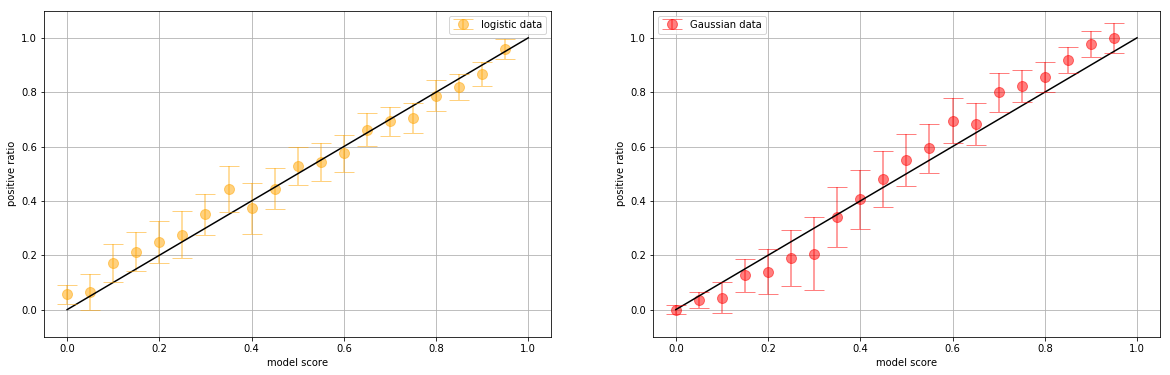

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ratio_logistic, err_logistic, e = get_positive_ratio(model, X_test, y_logistic, 1000, 20)

ax[0].plot([0,1], [0,1], '-', color='black')
ax[0].errorbar(x=e[:-1], y=ratio_logistic, yerr=err_logistic, fmt='o', color='orange', alpha=0.5, markersize=10, barsabove=True, capsize=10, label='logistic data')
ax[0].grid()
ax[0].set_xlabel("model score")
ax[0].set_ylabel("positive ratio")
ax[0].legend()
ax[0].set_ylim((-0.1,1.1))

ratio_normal, err_normal, e = get_positive_ratio(model, X_test, y_normal, 1000, 20)

ax[1].plot([0,1], [0,1], '-', color='black')
ax[1].errorbar(x=e[:-1], y=ratio_normal, yerr=err_normal, fmt='o', color='red', alpha=0.5, markersize=10, barsabove=True, capsize=10, label='Gaussian data')
ax[1].grid()
ax[1].set_xlabel("model score")
ax[1].set_ylabel("positive ratio")
ax[1].legend()
ax[1].set_ylim((-0.1,1.1));